# Classification Methods

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils

import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#import slideUtilities as sl
#import laUtilities as ut
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [4]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

## Examples with Synthetic Data

We consider and demonstrate the use of two classification methods: $k$-nearest neighbors and decision trees. For the examples we are considering, we will use synthetic data.

In [5]:
(X, y) = datasets.make_circles(noise=.1, factor=.5, random_state=1)
print('Shape of data: {}'.format(X.shape))
print('Unique labels: {}'.format(np.unique(y)))

Shape of data: (100, 2)
Unique labels: [0 1]


This data can be visualized in the following way.

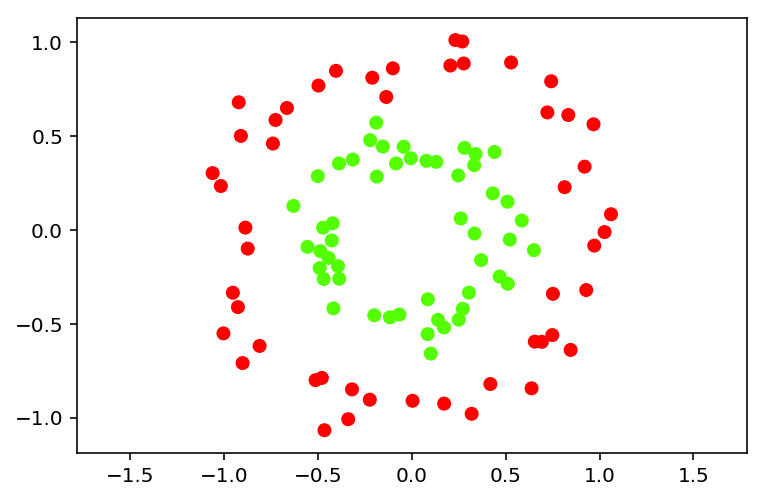

In [7]:
plt.prism()  # This sets a color map.
plt.scatter(X[:, 0], X[:, 1], c=y)
_ = plt.axis('equal')

We always want to test our classification techniques on a subset of our data that is separate from our training data. Thus, we will keep the first 50 examples for training and the rest for testing.

In [8]:
# Normally we would randomly permute the data rows first, 
# but this is random synthetic data so it's not necessary.
X_train = X[:50]
y_train = y[:50]
X_test = X[50:]
y_test = y[50:]

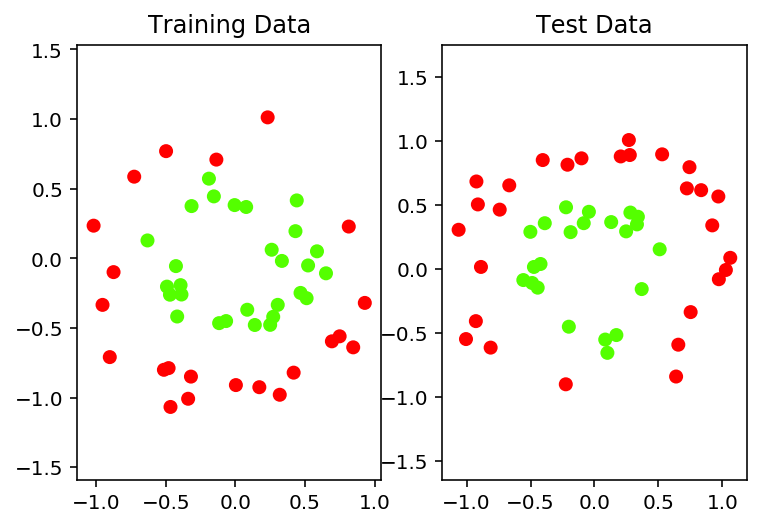

In [12]:
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, )
plt.axis('equal')
plt.title('Training Data')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test Data')
_ = plt.axis('equal')

### $k$- Nearest Neighbors

For our first example, we will classify the points (in the two classes) using a $k$-nn classifier. We will set $k=5$, which means we will classify based on the majority vote of the five nearest neighbors.

In [13]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)    

Within the context of supervised learning, the scikit-learn `fit()` function corresponds to __training__ and the `predict()` function corresponds to __testing__.

In [14]:
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))

Accuracy on test data: 0.72


We can also check how well the classifier performs on the training data, although that is not as important as its performance on the test data.

In [15]:
y_pred_train = knn.predict(X_train)
print('Accuracy on training data: {}'.format(knn.score(X_train, y_train)))

Accuracy on training data: 0.94


We can visualize the results.

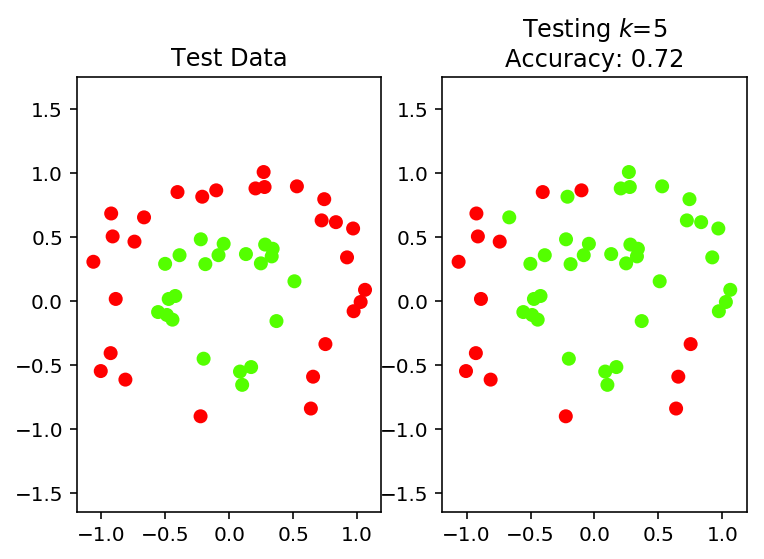

In [22]:
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test Data')
plt.axis('equal')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test)
plt.title('Testing $k$={}\nAccuracy: {}'.format(k,knn.score(X_test, y_test)))
_ = plt.axis('equal')

We look at one of the points that was classified incorrectly. We will also plot the decision region for the classifier, which will allow us to see which points the classifer predicts as belonging to each class.

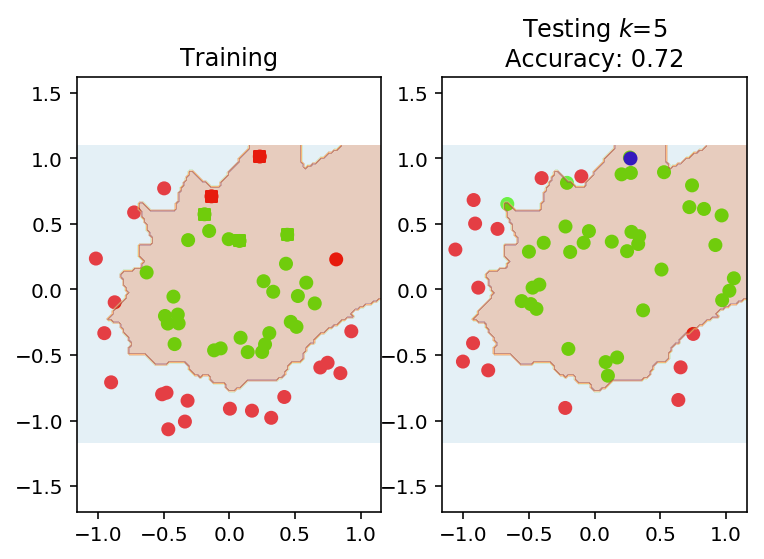

In [24]:
(x_min, x_max) = X[:, 0].min() - .1, X[:, 0].max() + .1
(y_min, y_max) = X[:, 1].min() - .1, X[:, 1].max() + .1
plot_step = 0.02

test_point = np.argmax(X_test[:,1])
X_test[test_point]
neighbors = knn.kneighbors([X_test[test_point]])[1]

# This code generates the information about the decision region.
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,)
plt.scatter(X_train[neighbors,0], X_train[neighbors,1], c = y_train[neighbors], marker='s', s=30)

plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

plt.axis('equal')
plt.title(r'Training')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test)
plt.scatter(X_test[test_point,0], X_test[test_point,1], c='b')
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

plt.title('Testing $k$={}\nAccuracy: {}'.format(k,knn.score(X_test, y_test)))
_ = plt.axis('equal')

For purposes of comparison, we can try $k = 3$.

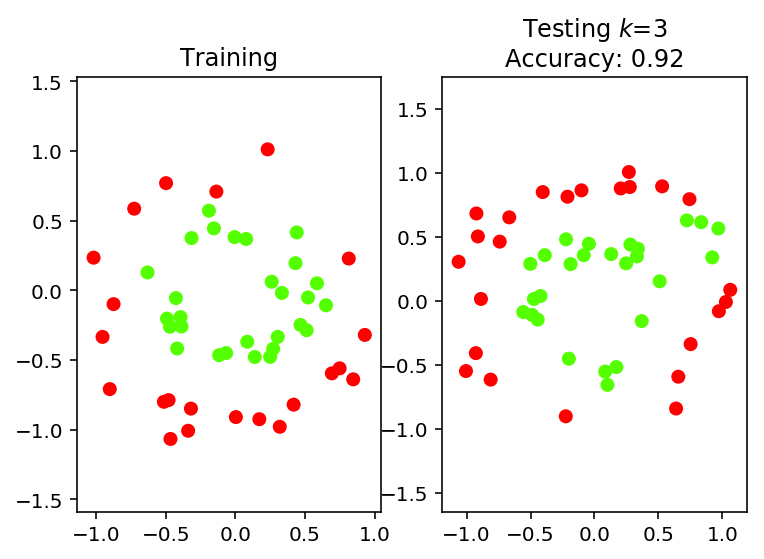

In [25]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)    
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, )
plt.axis('equal')
plt.title(r'Training')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test)
plt.title('Testing $k$={}\nAccuracy: {}'.format(k,knn.score(X_test, y_test)))
_=plt.axis('equal')

We look at the same individual point again.

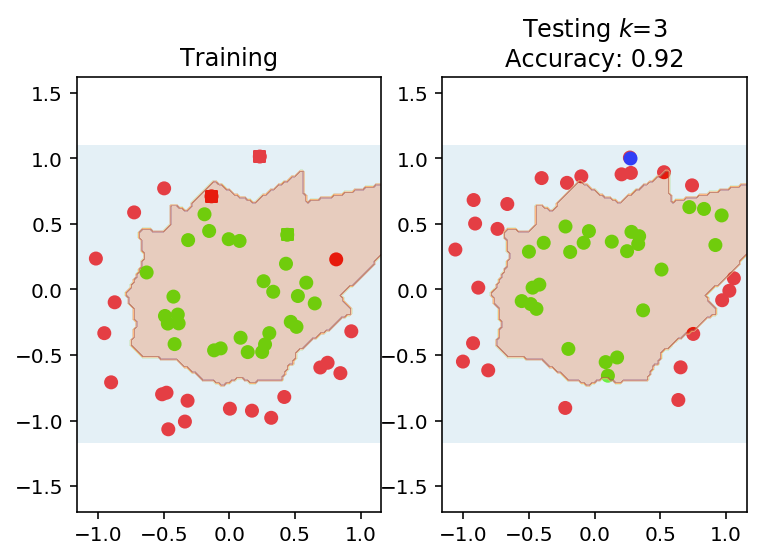

In [26]:
test_point = np.argmax(X_test[:,1])
X_test[test_point]
neighbors = knn.kneighbors([X_test[test_point]])[1]

# This code generates the information about the decision region.
(xx, yy) = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,)
plt.scatter(X_train[neighbors,0], X_train[neighbors,1], c = y_train[neighbors], marker='s', s=30)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.axis('equal')
plt.title(r'Training')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test)
plt.scatter(X_test[test_point,0], X_test[test_point,1], c='b')
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired,
                  alpha=0.3)
plt.title('Testing $k$={}\nAccuracy: {}'.format(k,knn.score(X_test, y_test)))
_ = plt.axis('equal')

### Decision Trees

We will now apply decision trees to the same synthetic data.

In [27]:
dtc = tree.DecisionTreeClassifier()

dtc.fit(X_train, y_train)
y_pred_test = dtc.predict(X_test)
print('DT accuracy on test data: ', dtc.score(X_test, y_test))
y_pred_train = dtc.predict(X_train)
print('DT accuracy on training data: ', dtc.score(X_train, y_train))

DT accuracy on test data:  0.92
DT accuracy on training data:  1.0


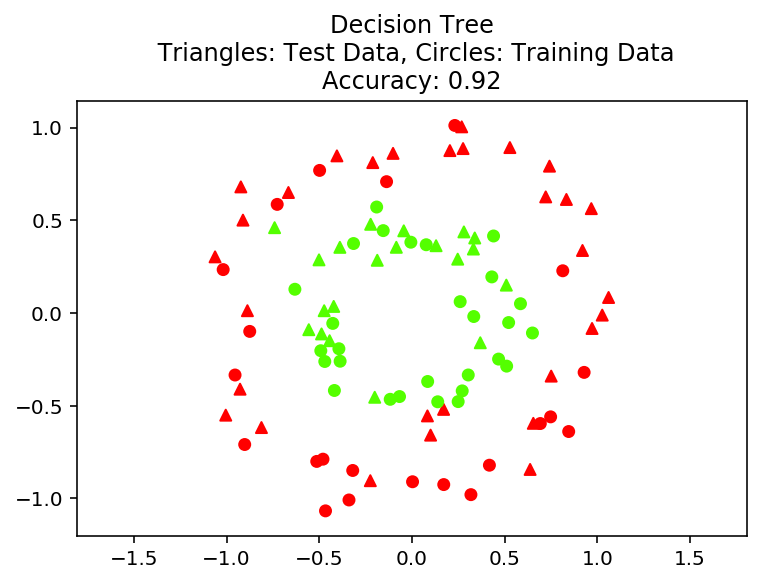

In [28]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='^',s=30)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)
plt.axis('equal')
_ = plt.title('Decision Tree\n Triangles: Test Data, Circles: Training Data\nAccuracy: {}'.format(dtc.score(X_test, y_test)))

We can visualize the __decision boundary__ of the decision tree.

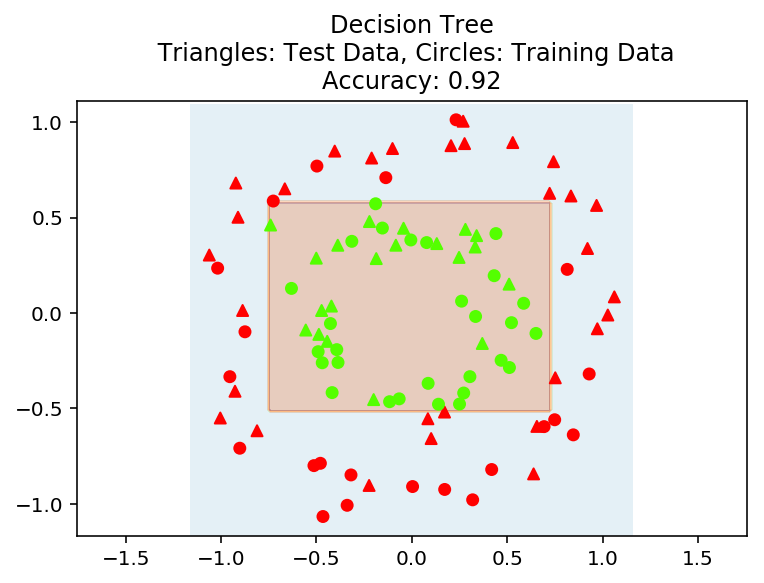

In [29]:
(x_min, x_max) = X[:, 0].min() - .1, X[:, 0].max() + .1
(y_min, y_max) = X[:, 1].min() - .1, X[:, 1].max() + .1
plot_step = 0.02
(xx, yy) = np.meshgrid(np.arange(x_min, x_max, plot_step),
                       np.arange(y_min, y_max, plot_step))

Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_test, marker='^',s=30)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)
plt.axis('equal')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
_ = plt.title('Decision Tree\n Triangles: Test Data, Circles: Training Data\nAccuracy: {}'.format(dtc.score(X_test, y_test)))

One of the benefits of a decision tree is that we can inspect the process it uses to classify a point. It is a "white box" in the sense that its decision rule can be interpreted by the user.

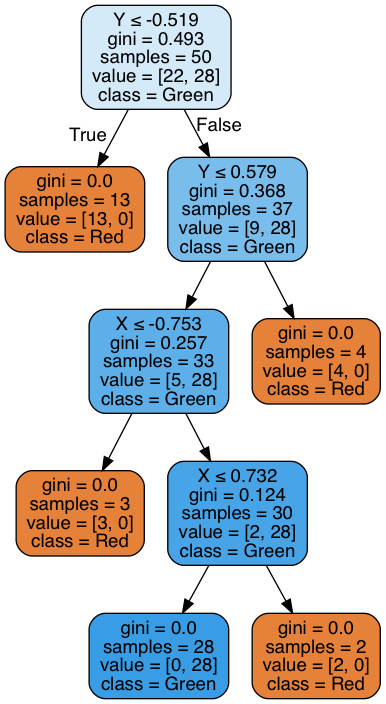

In [32]:
dot_data = tree.export_graphviz(dtc, out_file=None,
                         feature_names=['X','Y'],
                         class_names=['Red','Green'],
                         filled=True, rounded=True,  
                         special_characters=True) 
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data) 
# graph.write_pdf("dt.pdf") 
Image(graph.create_png())  

## The Iris Data Set

The [Iris data set](https://archive.ics.uci.edu/ml/datasets/Iris) is a well-known data set used by Ronald Fisher in a classic 1936 paper on classification. Quoting from Wikipedia:

>The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

In [34]:
iris = datasets.load_iris()

In [35]:
X = iris.data
y = iris.target
ynames = iris.target_names
print(X.shape, y.shape)
print(X[1,:])
print(iris.target_names)
print(y)

(150, 4) (150,)
[4.9 3.  1.4 0.2]
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


We split the data into training and testing subsets.

In [36]:
# Randomly shuffle the data.
(X, y) = utils.shuffle(X, y, random_state=1)
y

array([0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 2, 2,
       1, 2, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 0, 0, 2,
       0, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 2,
       0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 2,
       2, 2, 0, 0, 1, 0, 2, 0, 2, 2, 0, 2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 1, 2, 0])

In [37]:
train_set_size = 100
X_train = X[:train_set_size]  # Selects first 100 rows for training set.
y_train = y[:train_set_size]
X_test = X[train_set_size:]   # Selects from row 100 until the last one for testing set.
y_test = y[train_set_size:]
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

(100, 4)
(50, 4)


(None, (50,))

We classify using $k$-nearest neighbors, with $k$ = 5.

In [38]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

In [39]:
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
print("Accuracy on test set:", knn.score(X_test, y_test))

Accuracy on test set: 0.94


To gain some insight, we look at the decision boundary. Note that we will re-run the classifier using only two (of four) features so that we can visualize.

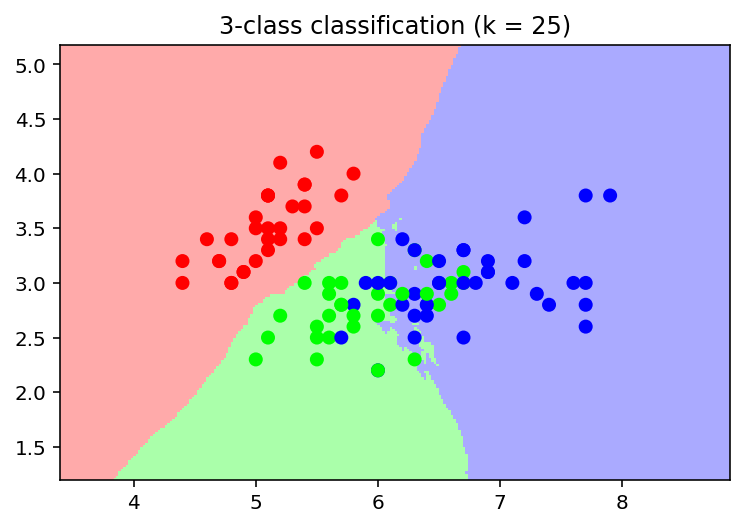

In [40]:
# Create color maps.
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# We will use only the first two (of four) features, so we can visualize.
X = X_train[:, :2] 
h = .02  # Step size in the mesh.
k = 25
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
(x_min, x_max) = X[:, 0].min() - 1, X[:, 0].max() + 1
(y_min, y_max) = X[:, 1].min() - 1, X[:, 1].max() + 1
(xx, yy) = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot the training points.
plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
_ = plt.title("3-class classification (k = {})".format(k))

In [41]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_test = dtc.predict(X_test)
print("Accuracy on test set:", dtc.score(X_test, y_test))

Accuracy on test set: 0.9


And now let's visualize the decision boundary for the decision tree:

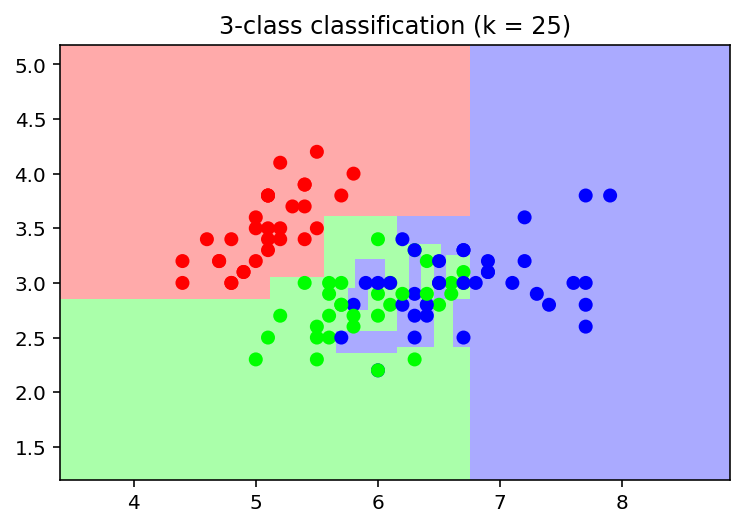

In [43]:
# We will use only the first two (of four) features, so we can visualize.
X = X_train[:, :2] 
h = .02  # Step size in the mesh.
dtc.fit(X, y_train)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
(x_min, x_max) = X[:, 0].min() - 1, X[:, 0].max() + 1
(y_min, y_max) = X[:, 1].min() - 1, X[:, 1].max() + 1
(xx, yy) = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot the training points.
plt.scatter(X[:, 0], X[:, 1], c=y_train, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
_ = plt.title("3-class classification (k = {})".format(k))

## MNIST Data Set

NIST used to be called the "National Bureau of Standards".  They are responsible for the reference meter, reference kilogram, etc. NIST constructed data sets of handwritten digits for machine learning ([MNIST](http://yann.lecun.com/exdb/mnist/)). These were collected from Census Bureau employees and also from high-school students.

In [44]:
digits = datasets.load_digits()
X_digits, y_digits = digits.data, digits.target

print ('Data shape: {}'.format(X_digits.shape))
print ('Data labels: {}'.format(y_digits))
print ('Unique labels: {}'.format(digits.target_names))
X_digits, y_digits = utils.shuffle(X_digits, y_digits, random_state=1)

Data shape: (1797, 64)
Data labels: [0 1 2 ... 8 9 8]
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [45]:
digits.images[3]

array([[ 0.,  0.,  7., 15., 13.,  1.,  0.,  0.],
       [ 0.,  8., 13.,  6., 15.,  4.,  0.,  0.],
       [ 0.,  2.,  1., 13., 13.,  0.,  0.,  0.],
       [ 0.,  0.,  2., 15., 11.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., 12., 12.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., 10.,  8.,  0.],
       [ 0.,  0.,  8.,  4.,  5., 14.,  9.,  0.],
       [ 0.,  0.,  7., 13., 13.,  9.,  0.,  0.]])

<Figure size 432x288 with 0 Axes>

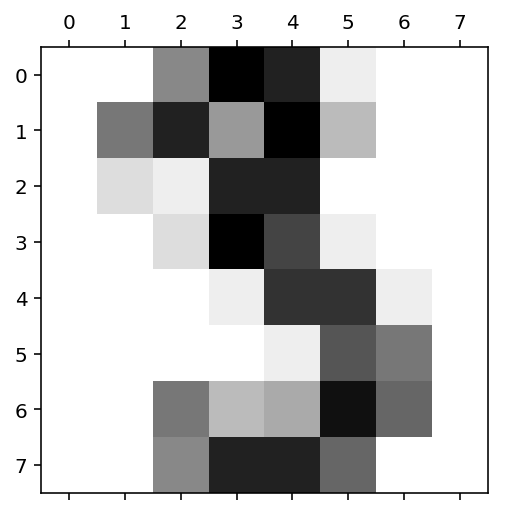

In [46]:
plt.gray() 
plt.rc('axes', grid=False)
_=plt.matshow(digits.images[3],cmap=plt.cm.gray_r) 

Notice that this is an $8 \times 8$ image. However we just treat it as a vector of length 64. It is easier to visualize if we blur the pixels a little bit.

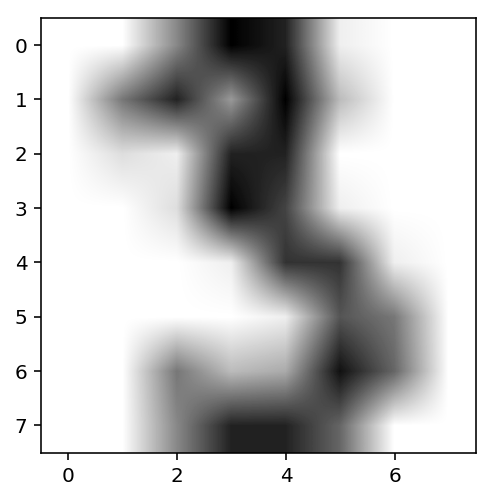

In [47]:
plt.rc('image', cmap='binary', interpolation='bilinear')
plt.rc('axes', grid=False)
plt.figure(figsize=(4,4))
_=plt.imshow(digits.images[3])

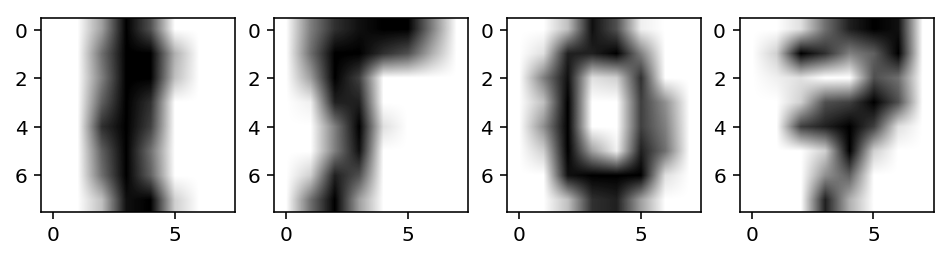

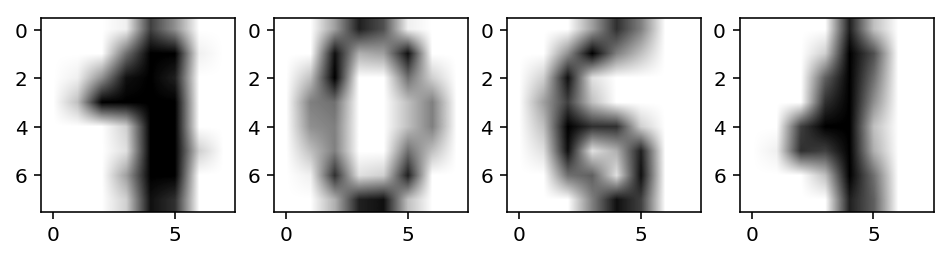

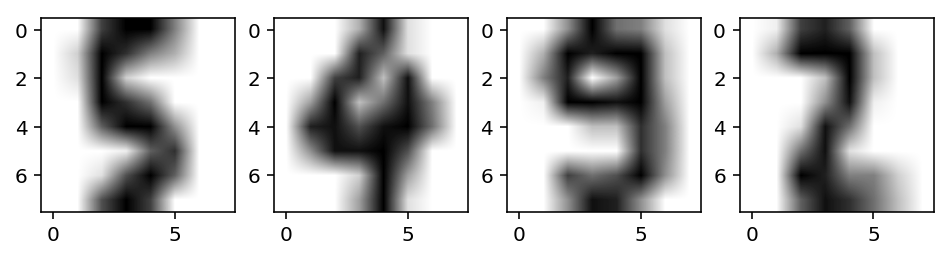

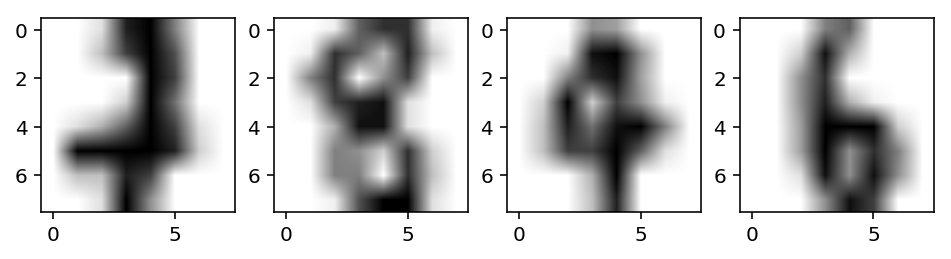

In [48]:
for t in range(4):
    plt.figure(figsize=(8,2))
    for j in range(4):
        plt.subplot(1, 4, 1 + j)
        plt.imshow(X_digits[4*t + j].reshape(8, 8))

This time we will use all classes, but only a small training set. This points out one issue of $k$-nearest neighbor: it can be slow on a large training set. To do model selection, we also create a test set to adjust $k$.

In [50]:
step = 1000;
X_digits_train = X_digits[:step]
y_digits_train = y_digits[:step]
X_digits_test = X_digits[step:len(y_digits)]
y_digits_test = y_digits[step:len(y_digits)]

knn_digits = KNeighborsClassifier(n_neighbors=20)
_ = knn_digits.fit(X_digits_train, y_digits_train)

In [51]:
acc = []
for k in range(1,60):
    knn_digits = KNeighborsClassifier(n_neighbors=k)
    knn_digits.fit(X_digits_train, y_digits_train)
    y_digits_test_pred = knn_digits.predict(X_digits_test)
    # print("KNN test accuracy on MNIST digits, k = {}, acc = {}: ".format(
            #k,knn_digits.score(X_digits_test, y_digits_test)))
    acc.append(knn_digits.score(X_digits_test, y_digits_test))

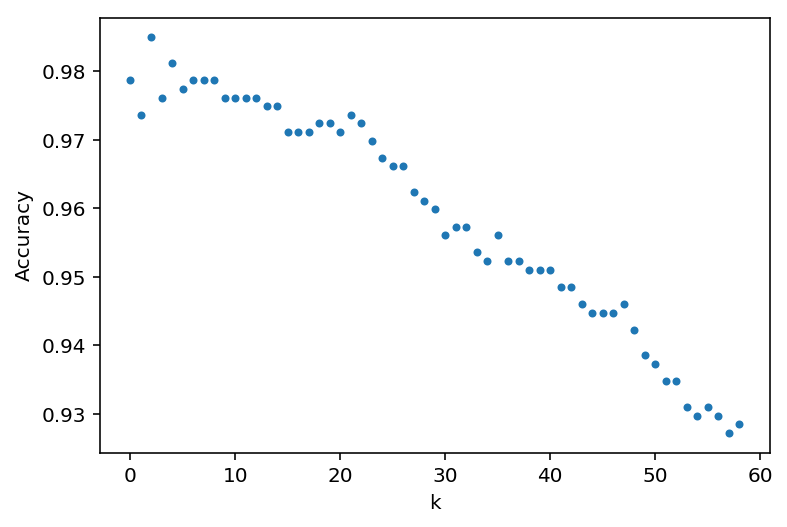

In [52]:
plt.plot(acc,'.')
plt.xlabel('k')
_ = plt.ylabel('Accuracy')

We can look at the nearest neighbors of some points (for $k=3$).

In [53]:
neighbors = knn_digits.kneighbors(X_digits_test, n_neighbors=3, return_distance=False)
print(type(neighbors))
print(neighbors.shape)

<class 'numpy.ndarray'>
(797, 3)


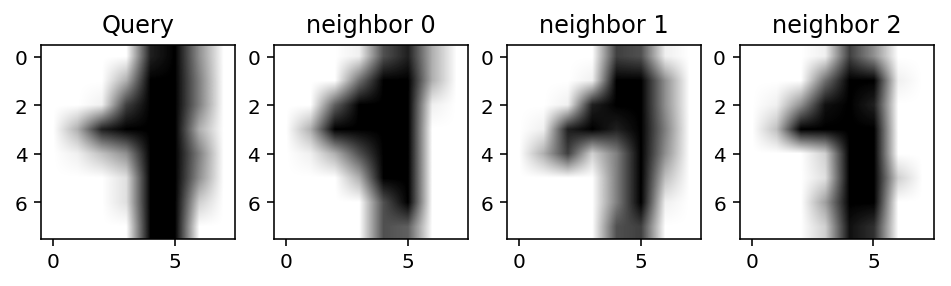

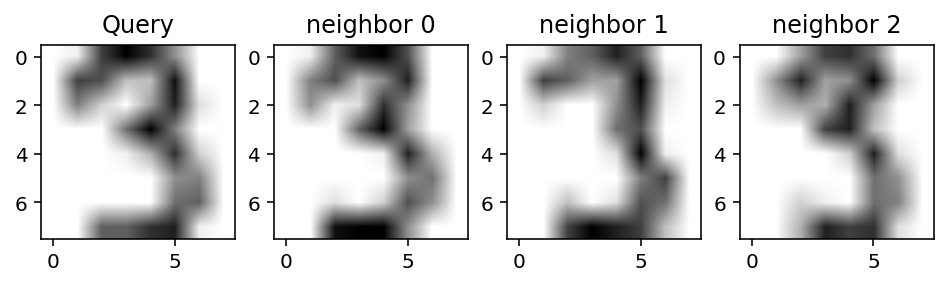

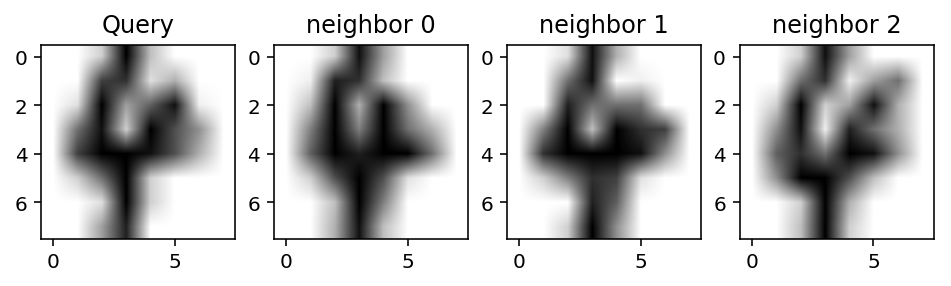

In [54]:
plt.rc("image", cmap="binary")  # this sets a black on white colormap
# plot X_digits_valid[0]
for t in range(3):
    plt.figure(figsize=(8,2))
    plt.subplot(1, 4, 1)
    plt.imshow(X_digits_test[t].reshape(8, 8))
    plt.title("Query")
    # plot three nearest neighbors from the training set
    for i in [0, 1, 2]:
        plt.subplot(1, 4, 2 + i)
        plt.title("neighbor {}".format(i))
        plt.imshow(X_digits_train[neighbors[t, i]].reshape(8, 8)) 